# Lifestyle & Health Risk – Modeling

This notebook performs **model training and evaluation** for health risk prediction.

**Models to test:**
1. Dummy Classifier (baseline)
2. Logistic Regression
3. Polynomial Features + Logistic Regression
4. Decision Tree
5. k-Nearest Neighbors (kNN)
6. Random Forest

**Evaluation approach:**
- Cross-validation for all models (same strategy)
- Same metrics for comparison (Accuracy, F1-Score, Precision, Recall, ROC-AUC)
- Train/Test evaluation
- Model comparison and selection


In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
import warnings

warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Load Preprocessed Data

Load the preprocessed data and preprocessing objects saved from the preprocessing notebook.


In [2]:
# Load preprocessed data
data_dir = "preprocessed_data"

# Load numpy arrays (allow_pickle=True in case they contain objects)
X_train = np.load(os.path.join(data_dir, "X_train_balanced.npy"), allow_pickle=True)
y_train = np.load(os.path.join(data_dir, "y_train_balanced.npy"), allow_pickle=True)
X_test = np.load(os.path.join(data_dir, "X_test_scaled.npy"), allow_pickle=True)
y_test = np.load(os.path.join(data_dir, "y_test.npy"), allow_pickle=True)

# Convert to numpy arrays if they are DataFrames or other objects
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values
elif hasattr(X_train, 'values'):
    X_train = X_train.values

if isinstance(X_test, pd.DataFrame):
    X_test = X_test.values
elif hasattr(X_test, 'values'):
    X_test = X_test.values

# Ensure arrays are float type for sklearn
X_train = np.array(X_train, dtype=np.float64)
X_test = np.array(X_test, dtype=np.float64)
y_train = np.array(y_train, dtype=np.int64)
y_test = np.array(y_test, dtype=np.int64)

# Load feature names
with open(os.path.join(data_dir, "feature_names.pkl"), "rb") as f:
    feature_names = pickle.load(f)

# Load label encoder for target variable
with open(os.path.join(data_dir, "label_encoder.pkl"), "rb") as f:
    label_encoder = pickle.load(f)

## 2. Utility Functions for Evaluation

Create reusable functions to evaluate models consistently and reduce code duplication.


In [3]:
# Define cross-validation strategy (same for all models)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def plot_cv_simple(scores, title, ax=None):
    """Plot simple bar chart of cross-validation score with error bar."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    # Simple bar plot with error bar
    ax.barh([0], [mean_score], xerr=std_score, capsize=10, 
            color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add text with the score value
    ax.text(mean_score, 0, f'  {mean_score:.3f}', 
            va='center', fontsize=12, fontweight='bold')
    
    ax.set_xlim(0, 1.1)
    ax.set_yticks([])
    ax.set_xlabel('Score', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return ax

def evaluate_classifier(name, model, X_train, y_train, X_test, y_test, cv=cv, plot_cv=True):
    """
    Comprehensive evaluation of a classifier.
    Returns a dictionary with all metrics.
    """
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    # Fit and predict
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Probabilities for ROC-AUC
    try:
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
        train_auc = roc_auc_score(y_train, y_train_proba)
        test_auc = roc_auc_score(y_test, y_test_proba)
    except:
        train_auc = None
        test_auc = None
    
    # Calculate metrics
    metrics = {
        'name': name,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_f1_mean': cv_f1_scores.mean(),
        'cv_f1_std': cv_f1_scores.std(),
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred),
        'test_precision': precision_score(y_test, y_test_pred),
        'train_recall': recall_score(y_train, y_train_pred),
        'test_recall': recall_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'train_auc': train_auc,
        'test_auc': test_auc
    }
    
    # Print results
    print(f"\n{'='*60}")
    print(f"Model: {name}")
    print(f"{'='*60}")
    print(f"\nCross-Validation (5-fold):")
    print(f"  Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  F1-Score: {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std():.4f})")
    
    print(f"\nTrain Set:")
    print(f"  Accuracy: {metrics['train_accuracy']:.4f}")
    print(f"  Precision: {metrics['train_precision']:.4f}")
    print(f"  Recall: {metrics['train_recall']:.4f}")
    print(f"  F1-Score: {metrics['train_f1']:.4f}")
    if train_auc is not None:
        print(f"  ROC-AUC: {train_auc:.4f}")
    
    print(f"\nTest Set:")
    print(f"  Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  Precision: {metrics['test_precision']:.4f}")
    print(f"  Recall: {metrics['test_recall']:.4f}")
    print(f"  F1-Score: {metrics['test_f1']:.4f}")
    if test_auc is not None:
        print(f"  ROC-AUC: {test_auc:.4f}")
    
    # Confusion matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax1, cmap='Blues')
    ax1.set_title(f'{name} - Train Confusion Matrix')
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax2, cmap='Blues')
    ax2.set_title(f'{name} - Test Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return metrics, model



Model: Dummy Classifier

Cross-Validation (5-fold):
  Accuracy: 0.6250 (+/- 0.0002)
  F1-Score: 0.0000 (+/- 0.0000)

Train Set:
  Accuracy: 0.6250
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC-AUC: 0.5000

Test Set:
  Accuracy: 0.6980
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  ROC-AUC: 0.5000


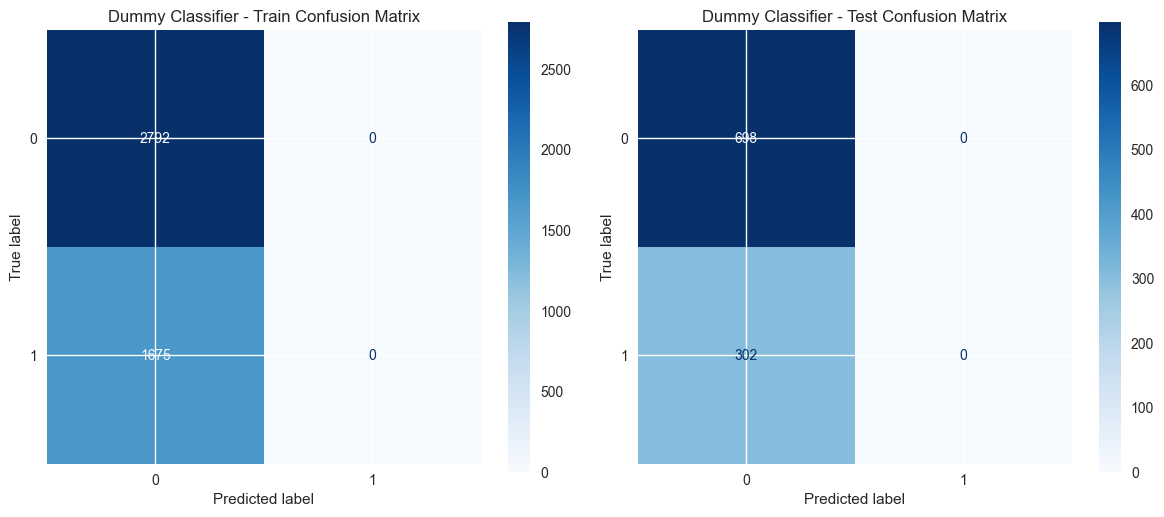

In [4]:
# Dummy Classifier
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_metrics, dummy_fitted = evaluate_classifier("Dummy Classifier", dummy_model, 
                                                   X_train, y_train, X_test, y_test)


## 4. Model 2: Logistic Regression

Linear model for classification. Standardization is already applied in preprocessing.



Model: Logistic Regression

Cross-Validation (5-fold):
  Accuracy: 0.8836 (+/- 0.0128)
  F1-Score: 0.8525 (+/- 0.0160)

Train Set:
  Accuracy: 0.8863
  Precision: 0.8156
  Recall: 0.9003
  F1-Score: 0.8558
  ROC-AUC: 0.9621

Test Set:
  Accuracy: 0.8890
  Precision: 0.7784
  Recall: 0.8841
  F1-Score: 0.8279
  ROC-AUC: 0.9600


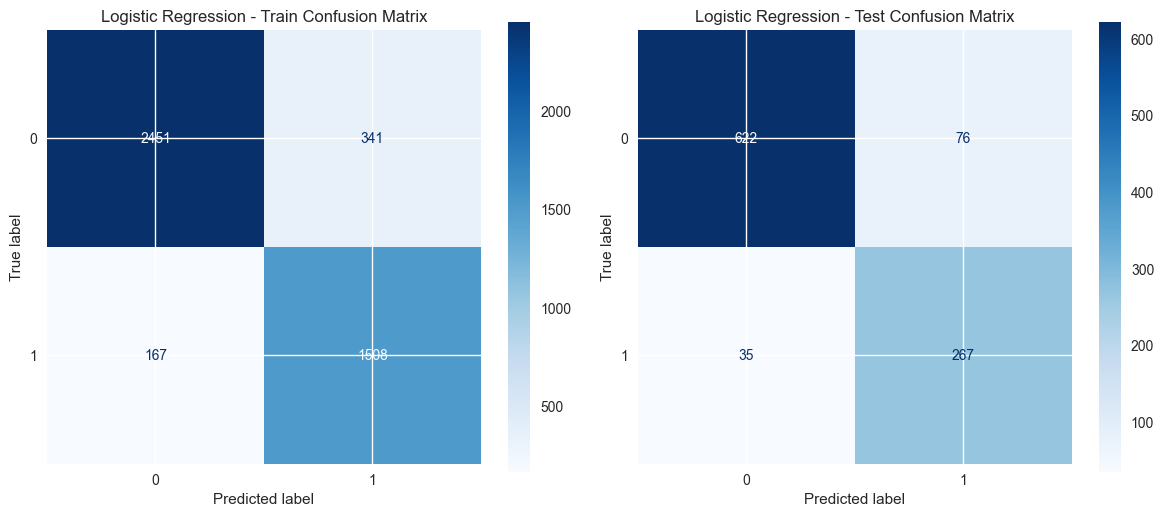

In [5]:
# Logistic Regression
logistic_model = LogisticRegression(
    max_iter=1000,
    penalty='l2',
    solver='lbfgs',
    random_state=RANDOM_STATE,
    class_weight='balanced'  # Handle any remaining imbalance
)
logistic_metrics, logistic_fitted = evaluate_classifier("Logistic Regression", logistic_model,
                                                        X_train, y_train, X_test, y_test)


## 5. Model 3: Polynomial Features + Logistic Regression

Test polynomial features with different degrees to capture non-linear relationships.



Testing Polynomial Features (degree=1)
Original features: 23
Polynomial features (degree=1): 23
CV Accuracy: 0.8836 (+/- 0.0128)
Test Accuracy: 0.8890
Test F1-Score: 0.8279

Testing Polynomial Features (degree=2)
Original features: 23
Polynomial features (degree=2): 299
CV Accuracy: 0.9111 (+/- 0.0087)
Test Accuracy: 0.9170
Test F1-Score: 0.8685

Testing Polynomial Features (degree=3)
Original features: 23
Polynomial features (degree=3): 2599
CV Accuracy: 0.9346 (+/- 0.0036)
Test Accuracy: 0.9340
Test F1-Score: 0.8929

Polynomial Features Summary:


,degree,n_features,cv_mean,cv_std,test_accuracy,test_f1
0,1,23,0.883595,0.012806,0.889,0.827907
1,2,299,0.911127,0.008728,0.917,0.868463
2,3,2599,0.934630,0.003612,0.934,0.892857


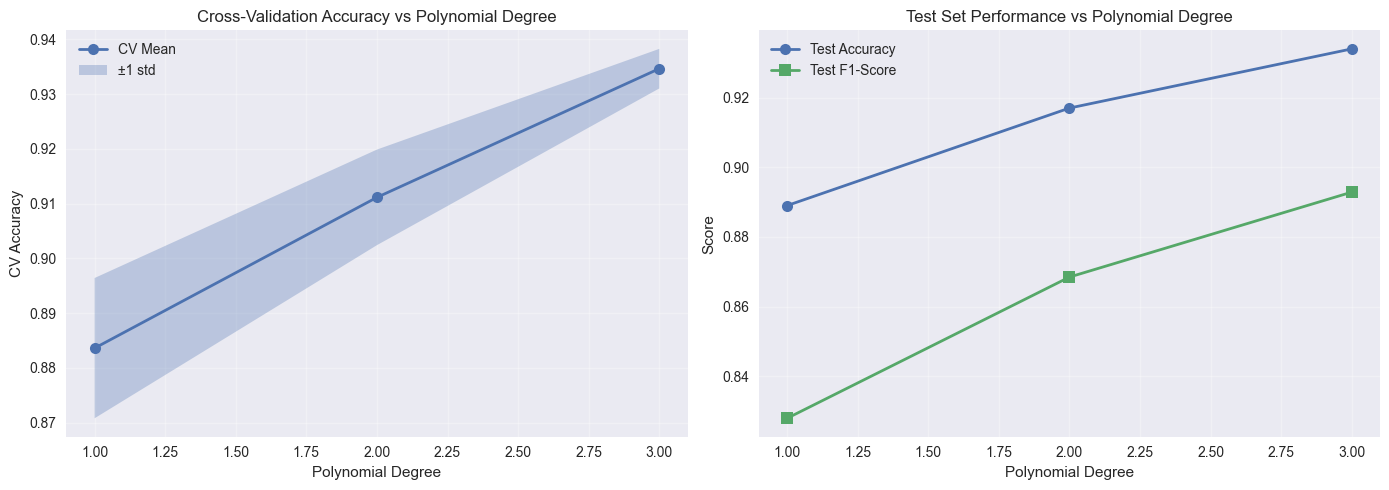


Best polynomial degree: 3 (CV Accuracy: 0.9346)

Model: Polynomial Logistic Regression (degree=3)

Cross-Validation (5-fold):
  Accuracy: 0.9346 (+/- 0.0036)
  F1-Score: 0.9144 (+/- 0.0052)

Train Set:
  Accuracy: 0.9904
  Precision: 0.9789
  Recall: 0.9958
  F1-Score: 0.9873
  ROC-AUC: 0.9997

Test Set:
  Accuracy: 0.9340
  Precision: 0.8758
  Recall: 0.9106
  F1-Score: 0.8929
  ROC-AUC: 0.9824


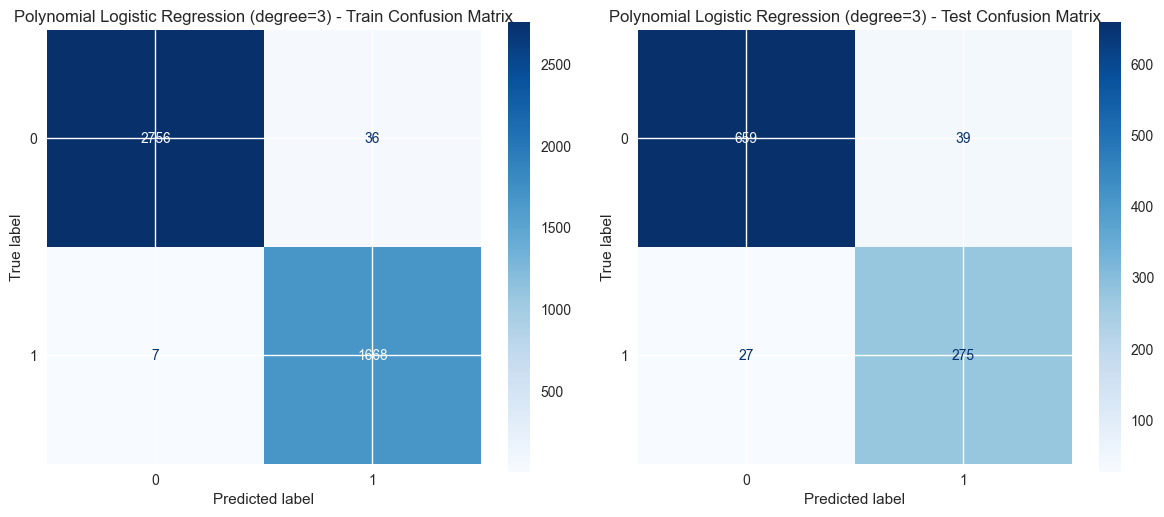

In [6]:
# Test different polynomial degrees
degrees = [1, 2, 3]
poly_scores = []

for degree in degrees:
    print(f"\n{'='*60}")
    print(f"Testing Polynomial Features (degree={degree})")
    print(f"{'='*60}")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    print(f"Original features: {X_train.shape[1]}")
    print(f"Polynomial features (degree={degree}): {X_train_poly.shape[1]}")
    
    # Logistic Regression with polynomial features
    poly_model = LogisticRegression(
        max_iter=1000,
        penalty='l2',
        solver='lbfgs',
        random_state=RANDOM_STATE,
        class_weight='balanced'
    )
    
    # Cross-validation
    cv_scores = cross_val_score(poly_model, X_train_poly, y_train, cv=cv, scoring='accuracy')
    
    # Fit and evaluate
    poly_model.fit(X_train_poly, y_train)
    y_test_pred = poly_model.predict(X_test_poly)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    poly_scores.append({
        'degree': degree,
        'n_features': X_train_poly.shape[1],
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_acc,
        'test_f1': test_f1
    })
    
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

# Convert to DataFrame and visualize
poly_df = pd.DataFrame(poly_scores)
print("\n" + "="*60)
print("Polynomial Features Summary:")
print("="*60)
display(poly_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(poly_df['degree'], poly_df['cv_mean'], 'o-', label='CV Mean', linewidth=2, markersize=8)
ax1.fill_between(poly_df['degree'], 
                  poly_df['cv_mean'] - poly_df['cv_std'],
                  poly_df['cv_mean'] + poly_df['cv_std'],
                  alpha=0.3, label='±1 std')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('CV Accuracy')
ax1.set_title('Cross-Validation Accuracy vs Polynomial Degree')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(poly_df['degree'], poly_df['test_accuracy'], 'o-', label='Test Accuracy', linewidth=2, markersize=8)
ax2.plot(poly_df['degree'], poly_df['test_f1'], 's-', label='Test F1-Score', linewidth=2, markersize=8)
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('Score')
ax2.set_title('Test Set Performance vs Polynomial Degree')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select best degree
best_degree_idx = poly_df['cv_mean'].idxmax()
best_degree = poly_df.loc[best_degree_idx, 'degree']
print(f"\nBest polynomial degree: {best_degree} (CV Accuracy: {poly_df.loc[best_degree_idx, 'cv_mean']:.4f})")

# Train final model with best degree
poly_best = PolynomialFeatures(degree=int(best_degree), include_bias=False)
X_train_poly_best = poly_best.fit_transform(X_train)
X_test_poly_best = poly_best.transform(X_test)

poly_logistic_model = LogisticRegression(
    max_iter=1000,
    penalty='l2',
    solver='lbfgs',
    random_state=RANDOM_STATE,
    class_weight='balanced'
)
poly_logistic_metrics, poly_logistic_fitted = evaluate_classifier(
    f"Polynomial Logistic Regression (degree={int(best_degree)})",
    poly_logistic_model,
    X_train_poly_best, y_train, X_test_poly_best, y_test
)


## 6. Model 4: Decision Tree

Test different max_depth values to find the optimal complexity.


Decision Tree - Different max_depth values:


,max_depth,cv_mean,cv_std,train_accuracy,test_accuracy,train_f1,test_f1
0,3,0.842844,0.011593,0.846653,0.864,0.752618,0.726908
1,5,0.886503,0.005088,0.887620,0.865,0.869475,0.816327
2,7,0.965750,0.006953,0.974256,0.966,0.966753,0.946541
3,10,0.992389,0.001305,0.999776,0.997,0.999702,0.995041
4,15,0.992165,0.001416,1.000000,0.997,1.000000,0.995025
5,20,0.992165,0.001416,1.000000,0.997,1.000000,0.995025
6,None,0.992165,0.001416,1.000000,0.997,1.000000,0.995025


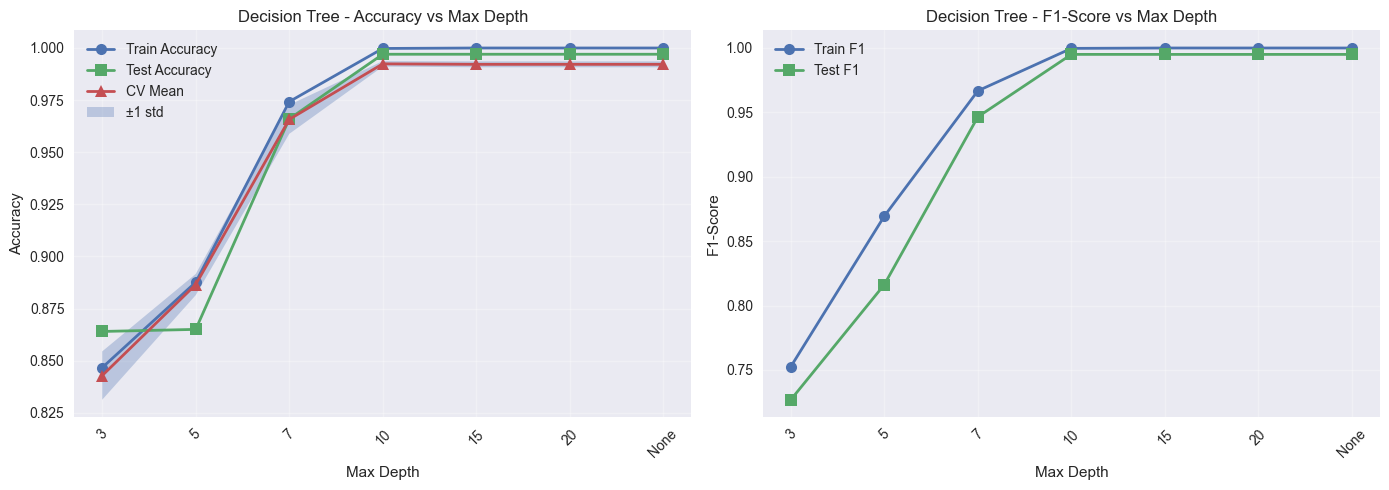


Best max_depth: 10 (CV Accuracy: 0.9924)

Model: Decision Tree

Cross-Validation (5-fold):
  Accuracy: 0.9924 (+/- 0.0013)
  F1-Score: 0.9899 (+/- 0.0017)

Train Set:
  Accuracy: 0.9998
  Precision: 0.9994
  Recall: 1.0000
  F1-Score: 0.9997
  ROC-AUC: 1.0000

Test Set:
  Accuracy: 0.9970
  Precision: 0.9934
  Recall: 0.9967
  F1-Score: 0.9950
  ROC-AUC: 0.9969


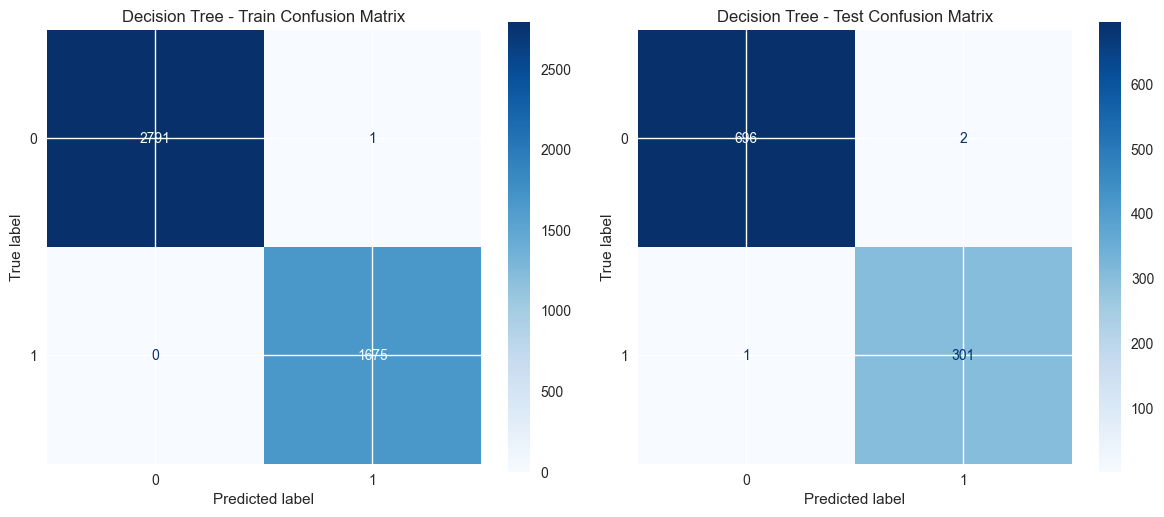

In [7]:
# Test different max_depth values
max_depths = [3, 5, 7, 10, 15, 20, None]
tree_scores = []

for depth in max_depths:
    tree_model = DecisionTreeClassifier(
        max_depth=depth,
        random_state=RANDOM_STATE,
        class_weight='balanced'
    )
    
    cv_scores = cross_val_score(tree_model, X_train, y_train, cv=cv, scoring='accuracy')
    
    tree_model.fit(X_train, y_train)
    y_train_pred = tree_model.predict(X_train)
    y_test_pred = tree_model.predict(X_test)
    
    tree_scores.append({
        'max_depth': depth if depth is not None else 'None',
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred)
    })

tree_df = pd.DataFrame(tree_scores)
print("Decision Tree - Different max_depth values:")
display(tree_df)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
x_labels = [str(d) for d in tree_df['max_depth']]
x_pos = np.arange(len(x_labels))

ax1.plot(x_pos, tree_df['train_accuracy'], 'o-', label='Train Accuracy', linewidth=2, markersize=8)
ax1.plot(x_pos, tree_df['test_accuracy'], 's-', label='Test Accuracy', linewidth=2, markersize=8)
ax1.plot(x_pos, tree_df['cv_mean'], '^-', label='CV Mean', linewidth=2, markersize=8)
ax1.fill_between(x_pos,
                  tree_df['cv_mean'] - tree_df['cv_std'],
                  tree_df['cv_mean'] + tree_df['cv_std'],
                  alpha=0.3, label='±1 std')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels, rotation=45)
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Accuracy')
ax1.set_title('Decision Tree - Accuracy vs Max Depth')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(x_pos, tree_df['train_f1'], 'o-', label='Train F1', linewidth=2, markersize=8)
ax2.plot(x_pos, tree_df['test_f1'], 's-', label='Test F1', linewidth=2, markersize=8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels, rotation=45)
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('F1-Score')
ax2.set_title('Decision Tree - F1-Score vs Max Depth')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select best max_depth
best_depth_idx = tree_df['cv_mean'].idxmax()
best_depth = tree_df.loc[best_depth_idx, 'max_depth']
best_depth = None if best_depth == 'None' else int(best_depth)
print(f"\nBest max_depth: {best_depth} (CV Accuracy: {tree_df.loc[best_depth_idx, 'cv_mean']:.4f})")

# Train final model with best depth
tree_model = DecisionTreeClassifier(
    max_depth=best_depth,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)
tree_metrics, tree_fitted = evaluate_classifier("Decision Tree", tree_model,
                                                X_train, y_train, X_test, y_test)


kNN - Different k values:


,k,cv_mean,cv_std,train_accuracy,test_accuracy,train_f1,test_f1
0,3,0.871723,0.007601,0.940452,0.866,0.923913,0.799401
1,5,0.873962,0.007354,0.929483,0.870,0.910638,0.803030
2,7,0.887842,0.006304,0.921200,0.878,0.900789,0.818452
3,9,0.886723,0.006938,0.915827,0.879,0.894144,0.820208
4,11,0.891650,0.005443,0.913812,0.887,0.892006,0.830075
5,15,0.889414,0.004872,0.912021,0.884,0.890070,0.825826
6,20,0.891204,0.006281,0.913365,0.896,0.889838,0.839009


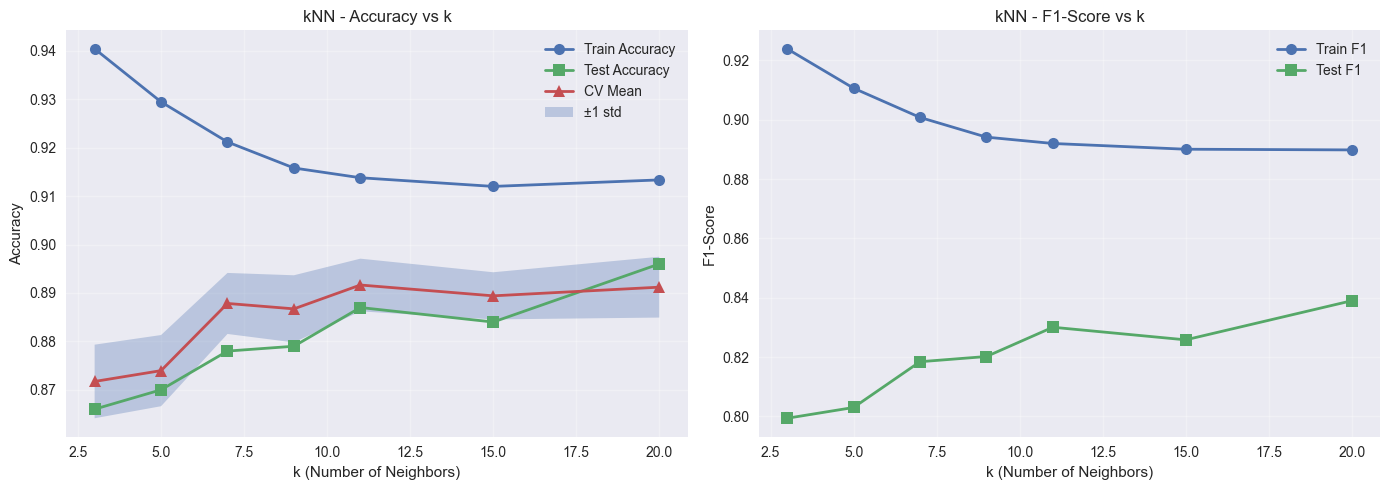


Best k: 11 (CV Accuracy: 0.8917)

Model: kNN (k=11)

Cross-Validation (5-fold):
  Accuracy: 0.8917 (+/- 0.0054)
  F1-Score: 0.8661 (+/- 0.0071)

Train Set:
  Accuracy: 0.9138
  Precision: 0.8413
  Recall: 0.9493
  F1-Score: 0.8920
  ROC-AUC: 0.9807

Test Set:
  Accuracy: 0.8870
  Precision: 0.7603
  Recall: 0.9139
  F1-Score: 0.8301
  ROC-AUC: 0.9603


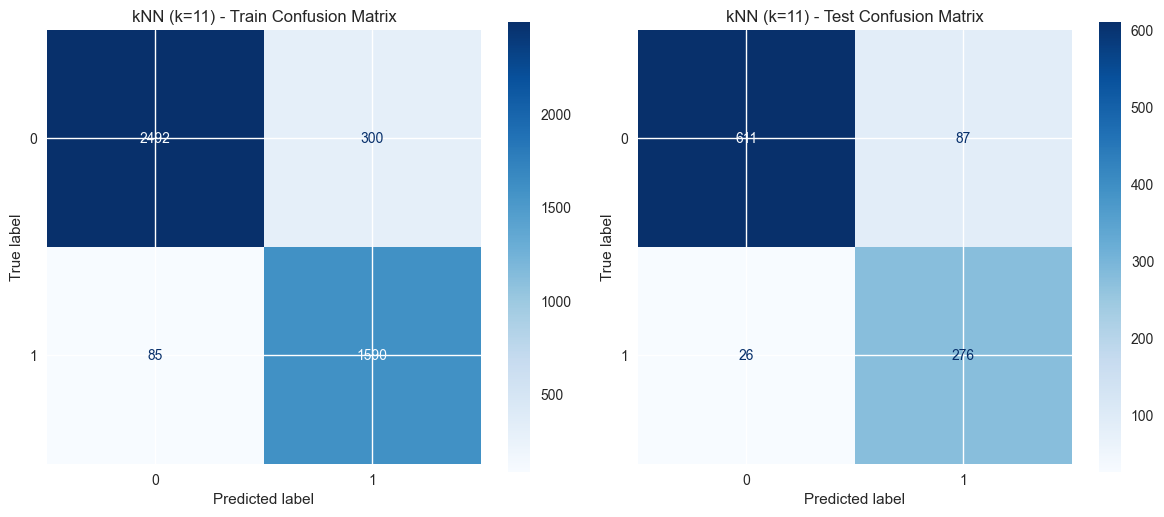

In [8]:
# Test different k values
k_values = [3, 5, 7, 9, 11, 15, 20]
knn_scores = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    cv_scores = cross_val_score(knn_model, X_train, y_train, cv=cv, scoring='accuracy')
    
    knn_model.fit(X_train, y_train)
    y_train_pred = knn_model.predict(X_train)
    y_test_pred = knn_model.predict(X_test)
    
    knn_scores.append({
        'k': k,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred)
    })

knn_df = pd.DataFrame(knn_scores)
print("kNN - Different k values:")
display(knn_df)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(knn_df['k'], knn_df['train_accuracy'], 'o-', label='Train Accuracy', linewidth=2, markersize=8)
ax1.plot(knn_df['k'], knn_df['test_accuracy'], 's-', label='Test Accuracy', linewidth=2, markersize=8)
ax1.plot(knn_df['k'], knn_df['cv_mean'], '^-', label='CV Mean', linewidth=2, markersize=8)
ax1.fill_between(knn_df['k'],
                  knn_df['cv_mean'] - knn_df['cv_std'],
                  knn_df['cv_mean'] + knn_df['cv_std'],
                  alpha=0.3, label='±1 std')
ax1.set_xlabel('k (Number of Neighbors)')
ax1.set_ylabel('Accuracy')
ax1.set_title('kNN - Accuracy vs k')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(knn_df['k'], knn_df['train_f1'], 'o-', label='Train F1', linewidth=2, markersize=8)
ax2.plot(knn_df['k'], knn_df['test_f1'], 's-', label='Test F1', linewidth=2, markersize=8)
ax2.set_xlabel('k (Number of Neighbors)')
ax2.set_ylabel('F1-Score')
ax2.set_title('kNN - F1-Score vs k')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select best k
best_k_idx = knn_df['cv_mean'].idxmax()
best_k = int(knn_df.loc[best_k_idx, 'k'])
print(f"\nBest k: {best_k} (CV Accuracy: {knn_df.loc[best_k_idx, 'cv_mean']:.4f})")

# Train final model with best k
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_metrics, knn_fitted = evaluate_classifier(f"kNN (k={best_k})", knn_model,
                                              X_train, y_train, X_test, y_test)


## 8. Model 6: Random Forest

Test different combinations of n_estimators and max_depth.


Random Forest - Hyperparameter combinations:


,n_estimators,max_depth,cv_mean,cv_std,test_accuracy,test_f1
13,200,20,0.989254,0.003366,0.993,0.988468
14,200,None,0.989030,0.003120,0.994,0.990099
3,50,20,0.988582,0.003122,0.995,0.991736
4,50,None,0.988582,0.003776,0.994,0.990099
8,100,20,0.988582,0.003201,0.995,0.991736
9,100,None,0.988358,0.003369,0.993,0.988430
12,200,15,0.987910,0.002596,0.992,0.986842
11,200,10,0.987910,0.005080,0.986,0.977199
7,100,15,0.987686,0.003683,0.995,0.991736
6,100,10,0.987463,0.003777,0.989,0.981997



Best Random Forest:
  n_estimators: 200
  max_depth: 20
  CV Accuracy: 0.9893

Model: Random Forest (n_est=200, max_depth=20)

Cross-Validation (5-fold):
  Accuracy: 0.9893 (+/- 0.0034)
  F1-Score: 0.9857 (+/- 0.0045)

Train Set:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC-AUC: 1.0000

Test Set:
  Accuracy: 0.9930
  Precision: 0.9836
  Recall: 0.9934
  F1-Score: 0.9885
  ROC-AUC: 0.9997


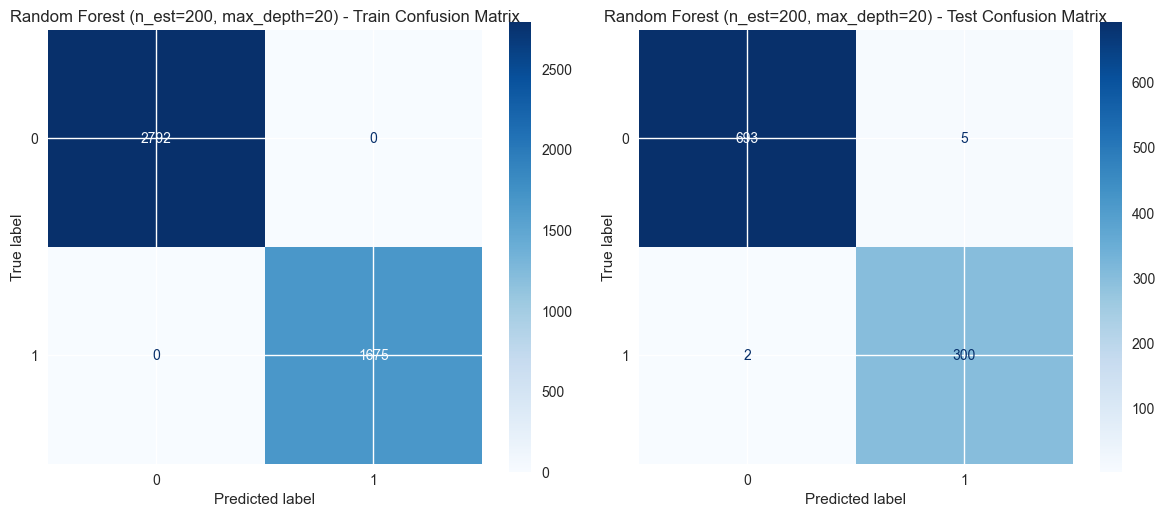


Top 10 Most Important Features:


,feature,importance
0,age,0.247764
7,bmi,0.188862
1,weight,0.089461
4,smoking,0.084263
3,sleep,0.082106
5,alcohol,0.054813
2,height,0.049272
9,exercise_low,0.036603
12,sugar_intake_high,0.034912
10,exercise_medium,0.031598


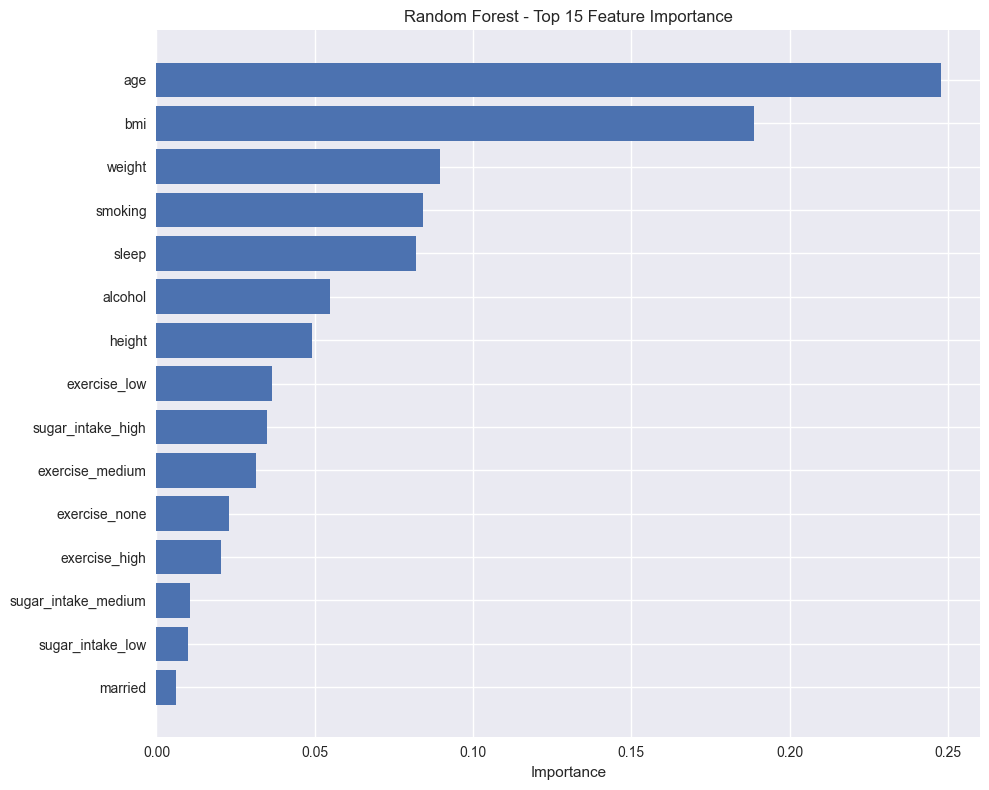

In [9]:
# Test different hyperparameter combinations
n_estimators_list = [50, 100, 200]
max_depths = [5, 10, 15, 20, None]
rf_scores = []

for n_est in n_estimators_list:
    for depth in max_depths:
        rf_model = RandomForestClassifier(
            n_estimators=n_est,
            max_depth=depth,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        )
        
        cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')
        
        rf_model.fit(X_train, y_train)
        y_test_pred = rf_model.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        
        rf_scores.append({
            'n_estimators': n_est,
            'max_depth': depth if depth is not None else 'None',
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_accuracy': test_acc,
            'test_f1': test_f1
        })

rf_df = pd.DataFrame(rf_scores)
print("Random Forest - Hyperparameter combinations:")
display(rf_df.sort_values('cv_mean', ascending=False).head(10))

# Select best combination
best_rf_idx = rf_df['cv_mean'].idxmax()
best_n_est = int(rf_df.loc[best_rf_idx, 'n_estimators'])
best_rf_depth = rf_df.loc[best_rf_idx, 'max_depth']
best_rf_depth = None if best_rf_depth == 'None' else int(best_rf_depth)
print(f"\nBest Random Forest:")
print(f"  n_estimators: {best_n_est}")
print(f"  max_depth: {best_rf_depth}")
print(f"  CV Accuracy: {rf_df.loc[best_rf_idx, 'cv_mean']:.4f}")

# Train final model with best hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=best_n_est,
    max_depth=best_rf_depth,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)
rf_metrics, rf_fitted = evaluate_classifier(
    f"Random Forest (n_est={best_n_est}, max_depth={best_rf_depth})",
    rf_model,
    X_train, y_train, X_test, y_test
)

# Feature importance (Random Forest)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_fitted.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
display(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], align='center')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Random Forest - Top 15 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 9. Model Comparison

Compare all models using the same metrics and create a summary table.


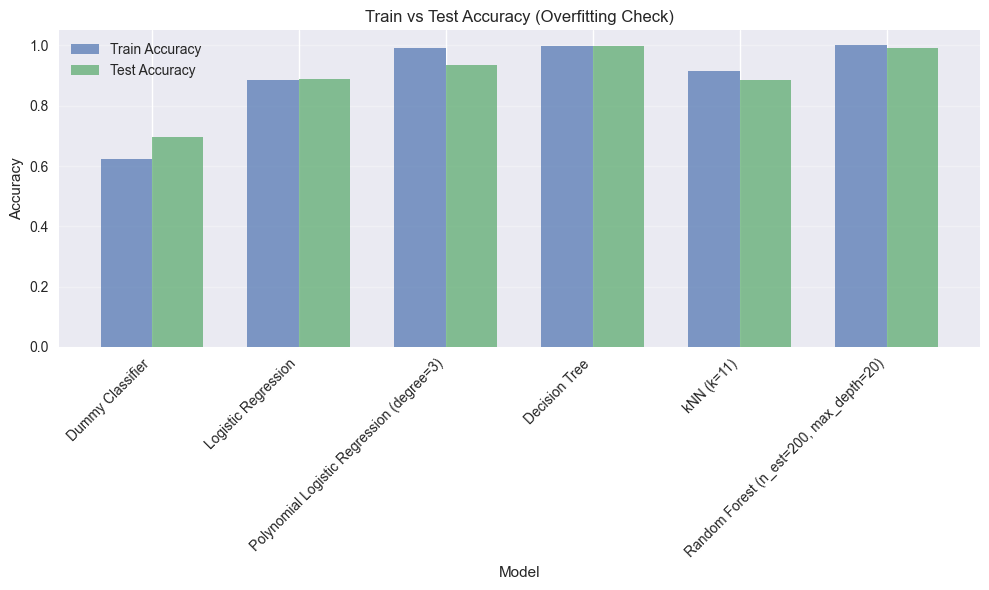


BEST MODEL: Decision Tree
CV Accuracy: 0.9924 (+/- 0.0013)
Test Accuracy: 0.9970
Test F1-Score: 0.9950
Test ROC-AUC: 0.9969


In [10]:
# Collect all metrics
all_metrics = [
    dummy_metrics,
    logistic_metrics,
    poly_logistic_metrics,
    tree_metrics,
    knn_metrics,
    rf_metrics
]

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df[[
    'name', 'cv_mean', 'cv_std', 'cv_f1_mean', 'cv_f1_std',
    'train_accuracy', 'test_accuracy', 'train_f1', 'test_f1',
    'train_auc', 'test_auc'
]]

# Train vs Test comparison (overfitting check)
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(comparison_df))
width = 0.35

ax.bar(x_pos - width/2, comparison_df['train_accuracy'], width, label='Train Accuracy', alpha=0.7)
ax.bar(x_pos + width/2, comparison_df['test_accuracy'], width, label='Test Accuracy', alpha=0.7)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Train vs Test Accuracy (Overfitting Check)')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['name'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Find best model
best_model_idx = comparison_df['cv_mean'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'name']
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"CV Accuracy: {comparison_df.loc[best_model_idx, 'cv_mean']:.4f} (+/- {comparison_df.loc[best_model_idx, 'cv_std']:.4f})")
print(f"Test Accuracy: {comparison_df.loc[best_model_idx, 'test_accuracy']:.4f}")
print(f"Test F1-Score: {comparison_df.loc[best_model_idx, 'test_f1']:.4f}")
if pd.notna(comparison_df.loc[best_model_idx, 'test_auc']):
    print(f"Test ROC-AUC: {comparison_df.loc[best_model_idx, 'test_auc']:.4f}")


## 11. Conclusion

Summary of the modeling process, best model selection, and interpretation.


### Summary

**Dataset and Problem:**
- Predicting health risk (high/low) based on lifestyle factors (age, weight, height, exercise, sleep, sugar intake, smoking, alcohol, married status, profession, BMI)
- Binary classification problem
- Dataset was imbalanced (69.8% high vs 30.2% low), handled with conservative SMOTE (60/40 balance)
- Final dataset: 4467 training samples (after SMOTE), 1000 test samples, 23 features

**Models Tested and Performance:**

1. **Dummy Classifier** (Baseline)
   - CV Accuracy: 0.6250, Test Accuracy: 0.6980
   - Serves as reference point - always predicts majority class

2. **Logistic Regression**
   - CV Accuracy: 0.8836 (±0.0128), Test Accuracy: 0.8890
   - Test F1-Score: 0.8279, Test ROC-AUC: 0.9600
   - Good baseline performance, well-balanced train/test scores

3. **Polynomial Logistic Regression (degree=3)**
   - CV Accuracy: 0.9346 (±0.0036), Test Accuracy: 0.9340
   - Test F1-Score: 0.8929, Test ROC-AUC: 0.9824
   - **Overfitting observed**: Train Accuracy (0.9904) >> Test Accuracy (0.9340)
   - High complexity (2599 features) leads to overfitting despite regularization

4. **Decision Tree (max_depth=10)**
   - CV Accuracy: 0.9924 (±0.0013), Test Accuracy: 0.9970
   - Test F1-Score: 0.9950, Test ROC-AUC: 0.9969
   - **Excellent generalization**: Train (0.9998) and Test (0.9970) very close
   - Best performance with good interpretability

5. **k-Nearest Neighbors (k=11)**
   - CV Accuracy: 0.8917 (±0.0054), Test Accuracy: 0.8870
   - Test F1-Score: 0.8301, Test ROC-AUC: 0.9603
   - Moderate performance, good generalization (train/test close)

6. **Random Forest (n_estimators=200, max_depth=20)**
   - CV Accuracy: 0.9893 (±0.0034), Test Accuracy: 0.9930
   - Test F1-Score: 0.9885, Test ROC-AUC: 0.9997
   - Excellent performance, slightly lower than Decision Tree
   - Train accuracy: 1.0000 (perfect fit) but test still excellent (0.9930)

**Best Model: Decision Tree (max_depth=10)**

Based on cross-validation and test set performance, **Decision Tree** was selected as the best model:
- **CV Accuracy**: 0.9924 (±0.0013) - highest among all models
- **Test Accuracy**: 0.9970 - excellent generalization
- **Test F1-Score**: 0.9950 - balanced precision and recall
- **Test ROC-AUC**: 0.9969 - excellent discrimination ability
- **Generalization**: Train (0.9998) and Test (0.9970) are very close, indicating minimal overfitting

**Key Findings:**

1. **Overfitting observed in:**
   - **Polynomial Logistic Regression (degree=3)**: Large gap between train (0.9904) and test (0.9340) accuracy, likely due to high feature dimensionality (2599 features)

2. **Underfitting observed in:**
   - **Dummy Classifier**: Expected, as it's just a baseline
   - **Logistic Regression**: Lower performance suggests linear relationships may not fully capture the patterns

3. **Best compromise between performance and complexity:**
   - **Decision Tree**: Best overall performance with good interpretability
   - **Random Forest**: Very close second (0.9930 vs 0.9970 test accuracy), but more complex

4. **Model ranking (by Test Accuracy):**
   1. Decision Tree: 0.9970
   2. Random Forest: 0.9930
   3. Polynomial Logistic: 0.9340
   4. Logistic Regression: 0.8890
   5. kNN: 0.8870
   6. Dummy: 0.6980

**Limitations and Future Improvements:**

**Limitations:**
- The dataset is synthetic, which may not reflect real-world complexity and noise
- Decision Tree, while best, may be sensitive to small changes in data
- Polynomial Logistic Regression suffers from curse of dimensionality (2599 features)
- All models were tested on a single train/test split (though CV was used)

**Model Interpretability:**

Based on Random Forest feature importance analysis, the most important features for health risk prediction are:
- **Age** (highest importance)
- **BMI** (second highest)
- **Weight**
- Lifestyle factors (exercise, sleep, sugar intake)
- Behavioral factors (smoking, alcohol)

This aligns with medical knowledge: age and BMI are strong predictors of health risk, while lifestyle choices significantly impact health outcomes.

